## Work distribution

Nose-balanced vs uniform sampling is compared. More detailed description is coming :)

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt

import numpy as np
from plotoptix import TkOptiX
from plotoptix.materials import m_dispersive_glass, m_mirror

Setup the raytracer using Tkinter GUI as the output target:

In [2]:
rt = TkOptiX(width=1280, height=960, start_now=False)

rt.set_param(
             save_albedo=True, save_normals=True, # keep albedo/normals available also when denoiser is not used
             min_accumulation_step=16,            # how often the noise map is updated in the noise-balanced modes
             max_accumulation_frames=512,         # max accumulation steps
            )

rt.set_uint("path_seg_range", 8, 16)

rt.set_background(0)
rt.set_ambient(0)

# we'll need that parameters later to undo gamma corection for the noise vizualisation
exposure = 1.1
gamma = 2.2
rt.set_float("tonemap_exposure", exposure)
rt.set_float("tonemap_gamma", gamma)
rt.add_postproc("Gamma")

Setup camera for each work distribution mode:

In [3]:
rt.setup_camera("cam1", cam_type="ThinLens", work_distribution="Uniform",
                eye=[-58, 85, 123], target=[1, -3, 0],
                aperture_radius=1.5, fov=15,
                glock=True
               )
rt.setup_camera("cam2", cam_type="ThinLens", work_distribution="AbsNoiseBalanced",
                eye=[-58, 85, 123], target=[1, -3, 0],
                aperture_radius=1.5, fov=15,
                glock=True
               )
rt.setup_camera("cam3", cam_type="ThinLens", work_distribution="RelNoiseBalanced",
                eye=[-58, 85, 123], target=[1, -3, 0],
                aperture_radius=1.5, fov=15,
                glock=True
               )

Load mesh, setup scene objects and light:

In [4]:
rt.setup_material("glass", m_dispersive_glass)
rt.setup_material("mirror", m_mirror)

rt.load_mesh_obj("data/utah-teapot-1.obj", mat="glass", c=500)

rt.set_data("sphere",
            pos=[
                [-16, -4.33, -15],
                [-25, -4.33, -10],
                [25, -4.33, 0],
                ],
            r=5, c=0.96, mat="mirror"
           )

rt.set_data("plane", geom="Parallelograms",
            pos=[-100, -9.33, -100], u=[200, 0, 0], v=[0, 0, 200],
            c=[0.71, 0.82, 0.93]
           )

rt.setup_area_light("light1",
                    center=[0, 30, -25], target=[0, 0, 0], u=65, v=6,
                    color=[9, 8, 7]
                   )

Start the GUI window.

In [5]:
rt.start()

SEM error and sample count are stored in unused 4th values of albedo and normals. Note, these values are available only in the noise-balanced mode and if albedo/normals are saved (configured with parameters at the notebook beginning).

<IPython.core.display.Javascript object>


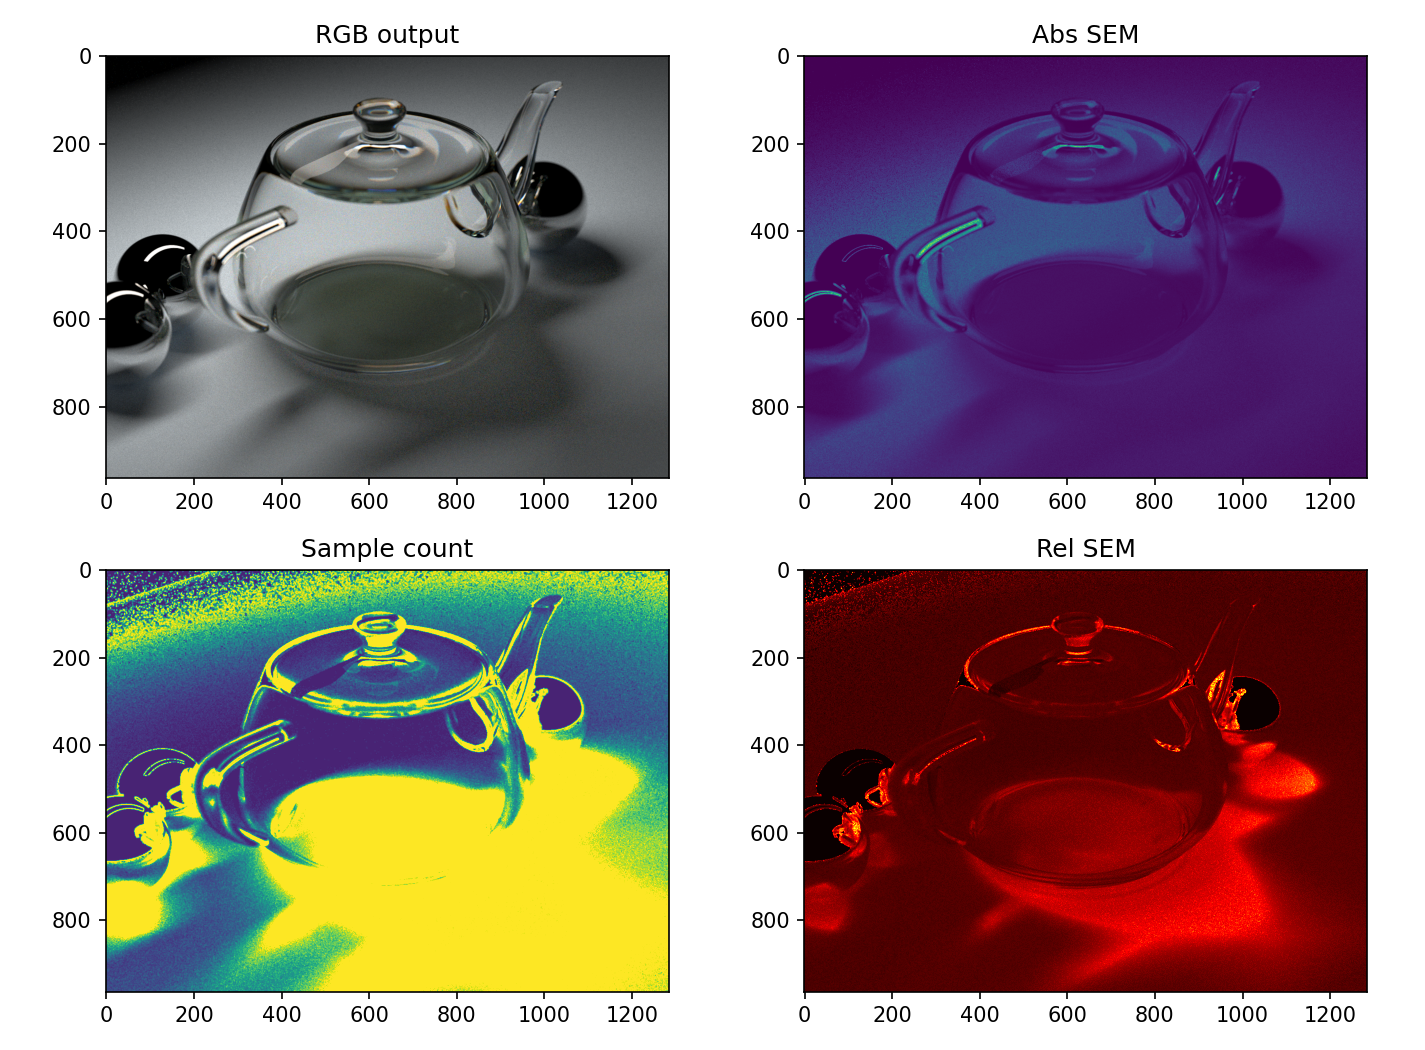

In [6]:
# Absolute sqrt(SEM) value, it is a good metric of the noise, though relative noise works better in practice.
sem = rt._albedo[:,:,3]

# Relative SEM.
ungamma = (1/exposure) * np.power(rt._raw_rgba[:,:,:3], gamma)
grayscale = np.dot(ungamma, [0.299, 0.587, 0.114])
grayscale[grayscale < 0.0001] = 1.0
ratio = sem / grayscale

# Samples/pixel count.
count = rt._normal[:,:,3]

figure, axis = plt.subplots(2, 2, figsize=(9.5,7))
rgb = axis[0, 0].imshow(rt._img_rgba)
axis[0, 0].set_title("RGB output")

sem_abs = axis[0, 1].imshow(sem, vmax=1)
axis[0, 1].set_title("Abs SEM")

sem_rel = axis[1, 1].imshow(ratio, vmax=1, cmap='hot')
axis[1, 1].set_title("Rel SEM")

cnt = axis[1, 0].imshow(count)
axis[1, 0].set_title("Sample count")

plt.tight_layout()

def image_ready(rt: TkOptiX) -> None:
    rgb.set_data(rt._img_rgba)
    
    sem = rt._albedo[:,:,3]
    sem_abs.set_data(sem)
    sem_abs.set_clim(vmin=0, vmax=max(1.0e-9, np.amax(sem)))

    ungamma = (1/exposure) * np.power(rt._raw_rgba[:,:,:3], gamma)
    grayscale = np.dot(ungamma, [0.299, 0.587, 0.114])
    grayscale[grayscale < 0.0001] = 1.0
    ratio = sem / grayscale
    sem_rel.set_data(ratio)
    sem_rel.set_clim(vmin=0, vmax=max(1.0e-9, np.amax(ratio)))

    count = rt._normal[:,:,3]
    cnt.set_data(count)
    cnt.set_clim(vmin=0, vmax=max(1, np.amax(count)))
    
    plt.draw()
    
# update figures on each accumulation frame:
rt.set_launch_finished_cb(image_ready)

Change the camera. Note, cam1 is sampling uniformly and has no stats available.

In [8]:
rt.set_current_camera("cam2")

Close the rey-tracer.

In [9]:
rt.close()